In [1]:
import urllib.request
import os
import matplotlib.pyplot as plt

In [2]:
# download tiny shakespear dataset

# uncomment below lines if you want to download dataset from the web
# url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
# if not os.path.exists(filename):
#     urllib.request.urlretrieve(url, filename)
#     print('Downloaded %s' % filename)

# pull from local folder
filename = 'tinyshakespeare.txt'
with open(filename, 'r') as f:
    text = f.read()

print(len(text))
print(text[:100])

1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [3]:
# get vocab
vocab = list(sorted(set(text)))
vocab_size = len(vocab)
print(f'length of vocab: {len(vocab)}')
print(f"entire vocabulary: {''.join(vocab)}")

length of vocab: 65
entire vocabulary: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [4]:
# character level encoding and decoding
stoi = {c: i for i, c in enumerate(vocab)}
# itos = {i: c for i, c in enumerate(vocab)}
# alternate way of creating decoder func
itos = {i: c for c, i in stoi.items()}
encode = lambda x: [stoi[c] for c in x]
decode = lambda x: ''.join([itos[i] for i in x])
print(encode('hello there !'))
print(decode(encode('yo whats up')))

[46, 43, 50, 50, 53, 1, 58, 46, 43, 56, 43, 1, 2]
yo whats up


In [5]:
import torch
# encode full dataset
data = torch.tensor(encode(text), dtype=torch.long)
print(data[:10])

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])


In [6]:
# train test split, 85% split
train_size = int(0.85 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]
print(f'train size: {len(train_data)}, test size: {len(test_data)}')

train size: 948084, test size: 167310


In [7]:
# sanity checking
print(decode(train_data.tolist()[:100]))

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [8]:
# create block sizes of 8
block_size = 8
train_dataset = data[:block_size + 1]
print(train_dataset)

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])


In [9]:
# show all packed training examples in a sampled batch size
x = train_dataset[:block_size]
y = train_dataset[1:block_size+1]
print(x)
print(y)
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f'context: {context}, target: {target}')


tensor([18, 47, 56, 57, 58,  1, 15, 47])
tensor([47, 56, 57, 58,  1, 15, 47, 58])
context: tensor([18]), target: 47
context: tensor([18, 47]), target: 56
context: tensor([18, 47, 56]), target: 57
context: tensor([18, 47, 56, 57]), target: 58
context: tensor([18, 47, 56, 57, 58]), target: 1
context: tensor([18, 47, 56, 57, 58,  1]), target: 15
context: tensor([18, 47, 56, 57, 58,  1, 15]), target: 47
context: tensor([18, 47, 56, 57, 58,  1, 15, 47]), target: 58


In [10]:
torch.manual_seed(1337)
batch_size = 4 # how many sequences we will process in parallel, each of these sequences is block_size long
block_size = 8 # the length of each sequence

def get_batch(split):
    data = train_data if split == 'train' else test_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

x, y = get_batch('train')
print(x)
print(y)
for xb in range(batch_size):
    for t in range(block_size):
        context = x[xb, :t+1]
        target = y[xb, t]
        print(f'context: {context}, target: {target}')


tensor([[53, 61, 57, 10,  0, 20, 43,  1],
        [39, 41, 43, 42,  1, 58, 46, 43],
        [52, 41, 43,  8,  0,  0, 24, 17],
        [26, 33, 31, 10,  0, 25, 53, 57]])
tensor([[61, 57, 10,  0, 20, 43,  1, 58],
        [41, 43, 42,  1, 58, 46, 43,  1],
        [41, 43,  8,  0,  0, 24, 17, 27],
        [33, 31, 10,  0, 25, 53, 57, 58]])
context: tensor([53]), target: 61
context: tensor([53, 61]), target: 57
context: tensor([53, 61, 57]), target: 10
context: tensor([53, 61, 57, 10]), target: 0
context: tensor([53, 61, 57, 10,  0]), target: 20
context: tensor([53, 61, 57, 10,  0, 20]), target: 43
context: tensor([53, 61, 57, 10,  0, 20, 43]), target: 1
context: tensor([53, 61, 57, 10,  0, 20, 43,  1]), target: 58
context: tensor([39]), target: 41
context: tensor([39, 41]), target: 43
context: tensor([39, 41, 43]), target: 42
context: tensor([39, 41, 43, 42]), target: 1
context: tensor([39, 41, 43, 42,  1]), target: 58
context: tensor([39, 41, 43, 42,  1, 58]), target: 46
context: tensor([

In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token in the lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both of shape (batch_size, block_size) aka (B, T)
        logits = self.token_embedding_table(idx) # Batch x time x channel
        if targets is None:
            loss = None
        else:
            # loss = F.cross_entropy(logits.view(-1, vocab_size), targets.view(-1)) # we could do this, but its hard to understand, so
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets) 

        return logits, loss

    # auto regressive generation
    def generate(self, idx, max_new_tokens):
        # idx is BxT
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            # pluck out last column in time dimension, because this is the generated predictions for what comes next
            logits = logits[:, -1, :] # keep only the last token for each sequence in the batch aka BxC
            probs = F.softmax(logits, dim=-1) # BxC
            # sample from the distribution
            next_tokens = torch.multinomial(probs, num_samples=1) # Bx1
            # append newly generated token to input idx to obtain new input for next generation iteration
            idx = torch.cat([idx, next_tokens], dim=1) # Bx(T+1)
        return idx

m = BigramLanguageModel(vocab_size)
x, y = get_batch('train')
logits, loss = m(x, y)
print(logits.shape)
print(loss)

idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))

torch.Size([32, 65])
tensor(4.7706, grad_fn=<NllLossBackward0>)

pxMHoRFJa!JKmRjtXzfN:CERiC-KuDHoiMIB!o3QHN
,SPyiFhRKuxZOMsB-ZJhsucL:wfzLSPyZalylgQUEU cLq,SqV&vW:hhi


### we see a loss of 4.77 which is worse than a uniform random guesser (which is our baseline comparison). and it is unsurprising that the next word guessing is worse because there is no training happening, and we're using only the one previous letter to find the next new one
### -ln(1/65) = 4.1743872699 which is the uniform random guesser model loss -> baseline to beat

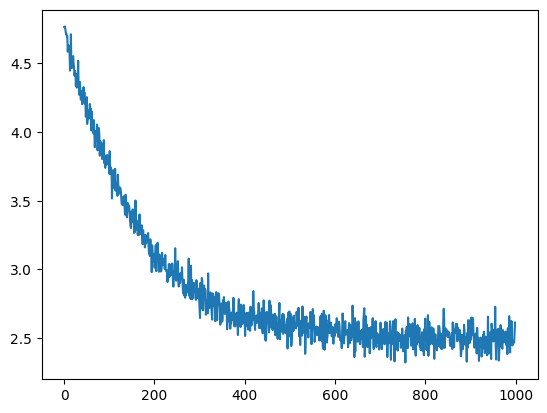

In [12]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-2)
batch_size = 32
losses = []

for _ in range(1000):
    # fetch batches
    x, y = get_batch('train')

    # forward pass
    logits, loss = m(x, y)

    # set gradients to zero at start of every new epoch
    optimizer.zero_grad(set_to_none=True)

    # backprop
    loss.backward()

    # gradient update
    optimizer.step()

    # track losses to plot loss curves
    losses.append(loss.item())
    
plt.plot(losses)

In [13]:
print(decode(m.generate(idx, max_new_tokens=500)[0].tolist()))


Whe hasd sthis; y, ue h bfinpr o ftherenethithenk ispaldore, ch me, D:
IZVAn;
RLLI le,
Froril y al t'e m aur ther t heathous.

XFMENoulay, d miof ou lol tou n ilnstoupESqulf my, dmy, sh tin:

AY bere ll! Che:
rdes inous wiqu and to lAnery gartofoot I 
NGldof Went pathO:vie it stis he callem Cld tino ghthat h llicoucowhave d memeip'shis!'d ks t ne'seediKIO: athmyo bure had soup,
I ort inorvefu y t pl le o m Gre dd ke in itsoom, hy :
K:

A dsh:
Thand om dilicLONous bugo thisty aght ?
Ale minchathy


# loss decreseases from 4.7 to 2.5 ish. and we see gibberish like outputs still but there is definitely an improvement